# XLM-Roberta Hate Speech Detection:

This notebook demonstrates hate speech detection using XLM-Roberta model on the provided dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW, get_linear_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')

# For contrastive learning
from torch.nn.functional import cosine_similarity
from tqdm import tqdm
import random

## 2. Load and Explore Dataset
Load the provided dataset and visualize the class distribution.

In [2]:
# Load dataset
DATA_PATH = 'Data Exploration/Final_Dataset'
df = pd.read_csv(DATA_PATH)
df = df.dropna(subset=['Comment', 'Annotation'])
df = df.reset_index(drop=True)
df.head()

,Comment,Annotation
0,"Dekho dalit log, reservation ke naam pe kitna ...",Hatespeech
1,"Hal hi me Gujrat me Dalit dolha ko mara gaya"" ...",Not Hatespeech
2,Yeh baat ne peesha mera canada mein bhi nhi sh...,Hatespeech
3,Ye to galat hua aapke sath ...😤😤😤😤,Not Hatespeech
4,O pagal uncle aunty jin baba saheb ke bare me...,Not Hatespeech


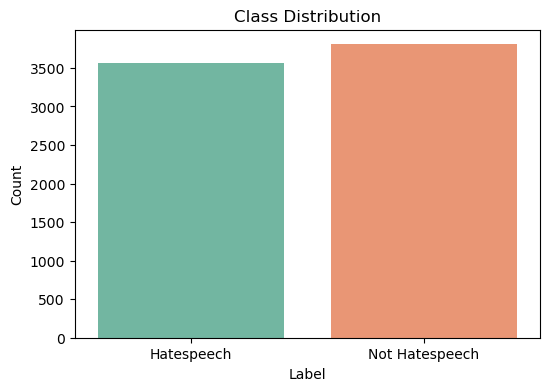

In [3]:
# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Annotation', data=df, palette='Set2')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## 3. Data Preprocessing and Visualization
Clean the text, encode labels, handle missing values, and visualize text length distributions.

Label mapping: {'Hatespeech': 0, 'Not Hatespeech': 1}


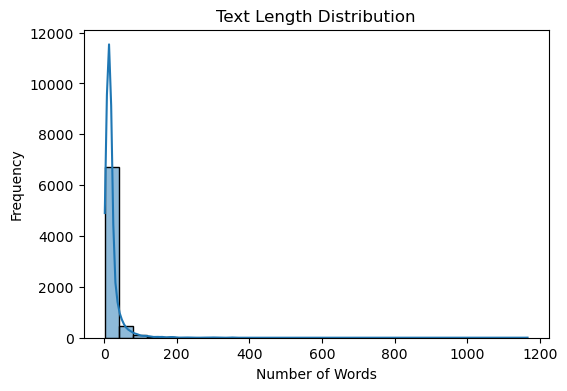

In [4]:
# Clean text (basic)
def clean_text(text):
    text = str(text).strip()
    return text

df['Comment'] = df['Comment'].apply(clean_text)

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['Annotation'])
print('Label mapping:', dict(zip(le.classes_, le.transform(le.classes_))))

# Visualize text length
df['text_len'] = df['Comment'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(6,4))
sns.histplot(df['text_len'], bins=30, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [5]:
max_words = df['Comment'].apply(lambda x: len(str(x).split())).max()
print("Maximum number of words in any comment:", max_words)
# Remove outlier comments with more than 400 words
df = df[df['text_len'] <= 400]

Maximum number of words in any comment: 1166


## 4. Train-Test Split
Split the dataset into training and test sets, and visualize label distribution in each split.

Train size: 5890, Test size: 1473


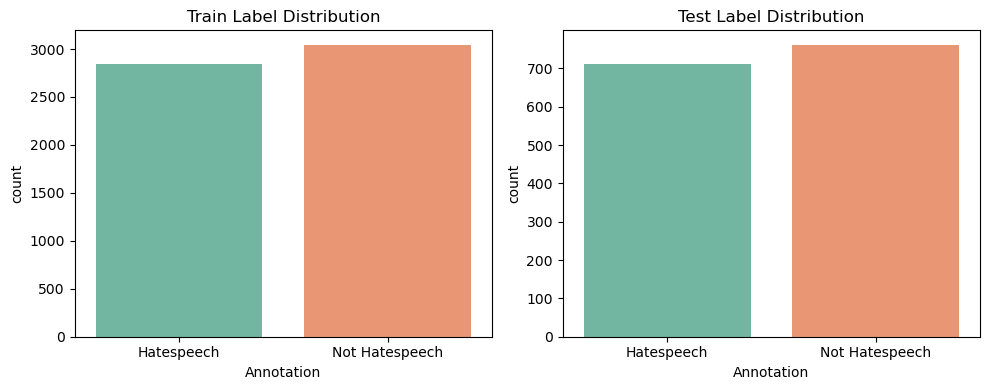

In [6]:
# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
print(f'Train size: {len(train_df)}, Test size: {len(test_df)}')

fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(x='Annotation', data=train_df, ax=ax[0], palette='Set2')
ax[0].set_title('Train Label Distribution')
sns.countplot(x='Annotation', data=test_df, ax=ax[1], palette='Set2')
ax[1].set_title('Test Label Distribution')
plt.tight_layout()
plt.show()

In [7]:
MAX_LEN = 400

# Convert data to PyTorch Dataset
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [8]:
# Define Transformer classifier
class TransformerClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs[1] if len(outputs) > 1 else outputs[0][:,0]
        return self.out(self.drop(pooled))

# Training loop (standard)
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler=None):
    model.train()
    losses, correct = [], 0
    for batch in tqdm(data_loader, desc='Training'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        _, preds = torch.max(outputs, dim=1)
        correct += torch.sum(preds == labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if scheduler: scheduler.step()
        optimizer.zero_grad()
    return np.mean(losses), correct.double() / len(data_loader.dataset)

def eval_epoch(model, data_loader, loss_fn, device):
    model.eval()
    losses, correct = [], 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            _, preds = torch.max(outputs, dim=1)
            correct += torch.sum(preds == labels)
            losses.append(loss.item())
    return np.mean(losses), correct.double() / len(data_loader.dataset)

In [9]:
# Evaluate on test set
def evaluate(model, data_loader, device):
    model.eval()
    predictions, true_labels, probs, embeddings, labels = [], [], [], [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['label']
            outputs = model(input_ids, attention_mask)
            bert_outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
            softmaxed = torch.softmax(outputs, dim=1)
            preds = torch.argmax(softmaxed, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(label.to(device).cpu().numpy())
            probs.extend(softmaxed.cpu().numpy())
            emb = bert_outputs[1].cpu().numpy() if len(bert_outputs) > 1 else bert_outputs[0][:,0].cpu().numpy()
            embeddings.append(emb)
            labels.extend(label.cpu().numpy())
    return np.array(predictions), np.array(true_labels), np.array(probs), np.concatenate(embeddings), np.array(labels)

# XLM-Roberta-base Model

In [10]:
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
import torch.nn as nn

# 1. Set up model and tokenizer for XLM-RoBERTa
MODEL_NAME = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
NUM_LABELS = len(le.classes_)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Prepare datasets and dataloaders
train_dataset = HateSpeechDataset(train_df['Comment'].tolist(), train_df['label'].tolist(), tokenizer, MAX_LEN)
test_dataset = HateSpeechDataset(test_df['Comment'].tolist(), test_df['label'].tolist(), tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 3. Initialize model, loss, optimizer, scheduler
model = TransformerClassifier(MODEL_NAME, NUM_LABELS).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*3)


Epoch 1/3


Training: 100%|██████████| 369/369 [2:26:35<00:00, 23.84s/it]    


Train Loss: 0.5055, Val Loss: 0.4254, Train Acc: 0.7525, Val Acc: 0.7970
Epoch 2/3


Training: 100%|██████████| 369/369 [1:11:31<00:00, 11.63s/it]


Train Loss: 0.3853, Val Loss: 0.3821, Train Acc: 0.8102, Val Acc: 0.8031
Epoch 3/3


Training: 100%|██████████| 369/369 [2:10:33<00:00, 21.23s/it]    


Train Loss: 0.3117, Val Loss: 0.3816, Train Acc: 0.8581, Val Acc: 0.8133


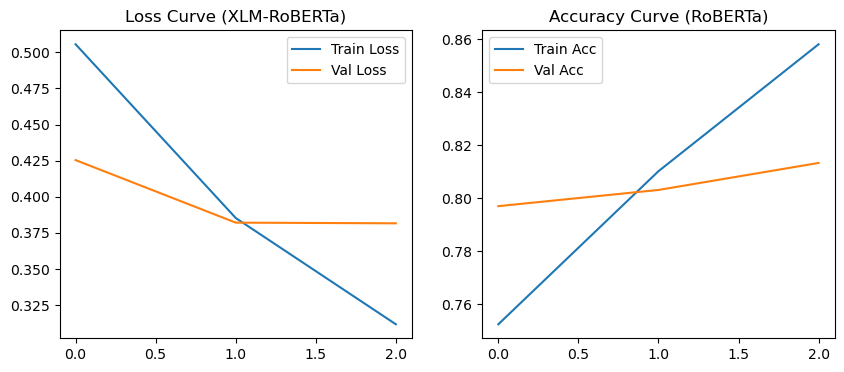

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


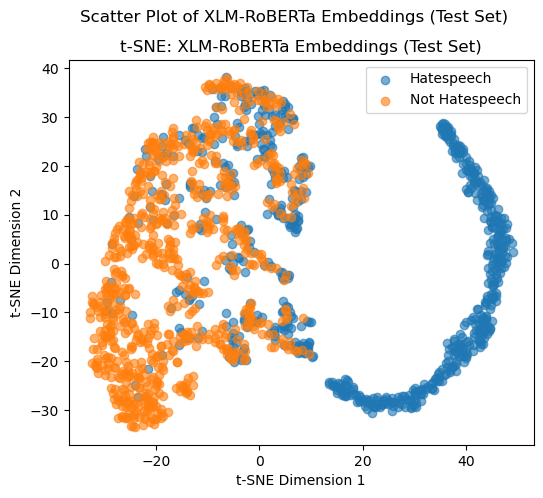

In [11]:
# 4. Training loop
EPOCHS = 3
train_losses, val_losses, train_accs, val_accs = [], [], [], []
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler)
    val_loss, val_acc = eval_epoch(model, test_loader, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

# 6. Evaluate and plot t-SNE scatter plot of embeddings
preds, trues, probs, emb_std, y_std = evaluate(model, test_loader, device)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
emb_std_2d = tsne.fit_transform(emb_std)

plt.figure(figsize=(6,5))
for i, label in enumerate(le.classes_):
    plt.scatter(emb_std_2d[y_std==i,0], emb_std_2d[y_std==i,1], label=label, alpha=0.6)
plt.title('t-SNE: XLM-RoBERTa Embeddings (Test Set)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.suptitle('Scatter Plot of XLM-RoBERTa Embeddings (Test Set)')
plt.show()

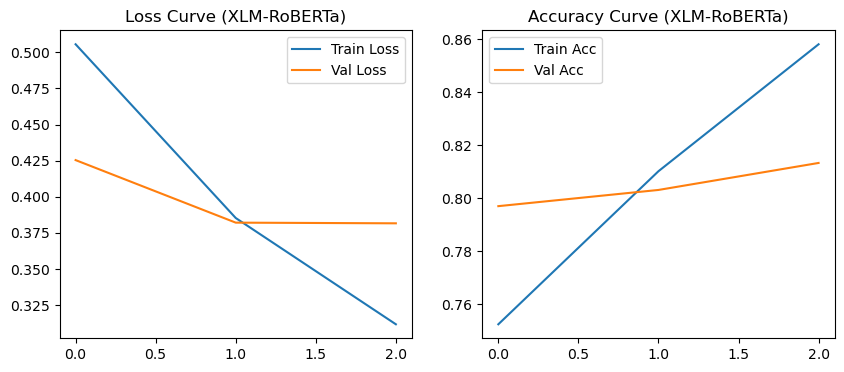

In [12]:
# 5. Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss Curve (XLM-RoBERTa)')
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title('Accuracy Curve (XLM-RoBERTa)')
plt.show()


Classification Report:
                precision    recall  f1-score   support

    Hatespeech       0.83      0.77      0.80       712
Not Hatespeech       0.80      0.86      0.83       761

      accuracy                           0.81      1473
     macro avg       0.82      0.81      0.81      1473
  weighted avg       0.81      0.81      0.81      1473



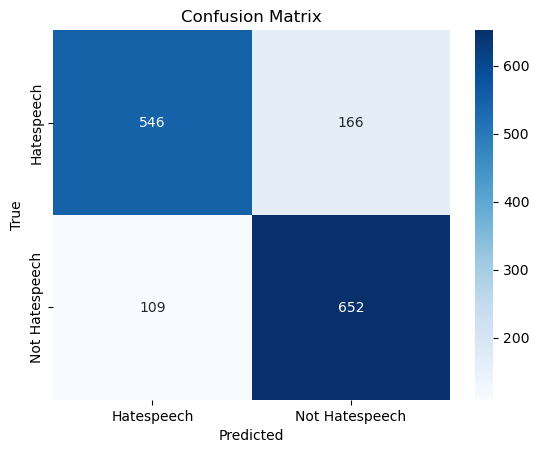

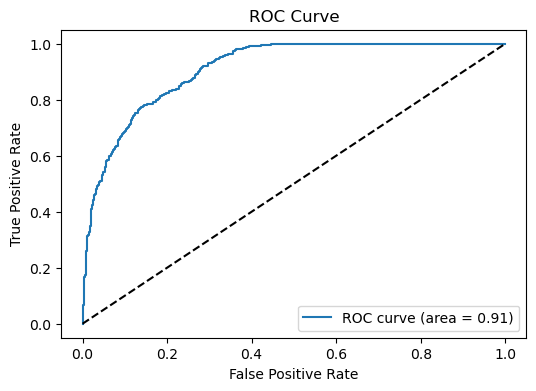

In [13]:
print('Classification Report:')
print(classification_report(trues, preds, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(trues, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(trues, probs[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()